In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
# Define paths
train_dir = "/kaggle/input/covid19-image-dataset/Covid19-dataset/train"
test_dir = "/kaggle/input/covid19-image-dataset/Covid19-dataset/test"

In [17]:
# Define classes
classes = ["Covid", "Normal", "Viral Pneumonia"]

In [18]:
# Print number of images in each class
for class_name in classes:
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    print(f"Train {class_name}: {len(os.listdir(train_class_dir))} images")
    print(f"Test {class_name}: {len(os.listdir(test_class_dir))} images")

Train Covid: 111 images
Test Covid: 26 images
Train Normal: 70 images
Test Normal: 20 images
Train Viral Pneumonia: 70 images
Test Viral Pneumonia: 20 images


In [19]:
# Data Preparation
img_size = (2746, 2382)
batch_size = 8

In [20]:
train_datagen = ImageDataGenerator(
    validation_split=0.2  # 20% of the data will be used for validation
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [21]:
# Model Architecture
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*img_size, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
#x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

In [22]:
model = Model(inputs=base_model.input, outputs=output)

In [23]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [24]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [26]:
# Model Training
epochs = 50  # Increased epochs, but we'll use early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


2024-08-29 13:59:30.130608: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k5=1,k6=0,k7=1,k10=1} for conv (f32[8,32,1373,1191]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,1373,1191]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-29 13:59:31.538046: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.40758728s
Trying algorithm eng12{k5=1,k6=0,k7=1,k10=1} for conv (f32[8,32,1373,1191]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,1373,1191]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", back

25/25 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.5177 - loss: 1.0430 - val_accuracy: 0.6458 - val_loss: 0.7754 - learning_rate: 0.0010
Epoch 2/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 17s 716ms/step - accuracy: 0.8750 - loss: 0.7004

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 649ms/step - accuracy: 0.8750 - loss: 0.7004 - val_accuracy: 0.5000 - val_loss: 0.9332 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7550 - loss: 0.5916 - val_accuracy: 0.6667 - val_loss: 0.7512 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.1907 - val_accuracy: 1.0000 - val_loss: 0.1555 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8972 - loss: 0.3126 - val_accuracy: 0.6458 - val_loss: 0.6723 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.1920 - val_accuracy: 1.0000 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8724 - loss: 0.2969 - val_accuracy: 0.7083 - val_loss: 0.6198 - learning_rate: 0.0010
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0424 - val_accuracy: 1.0000

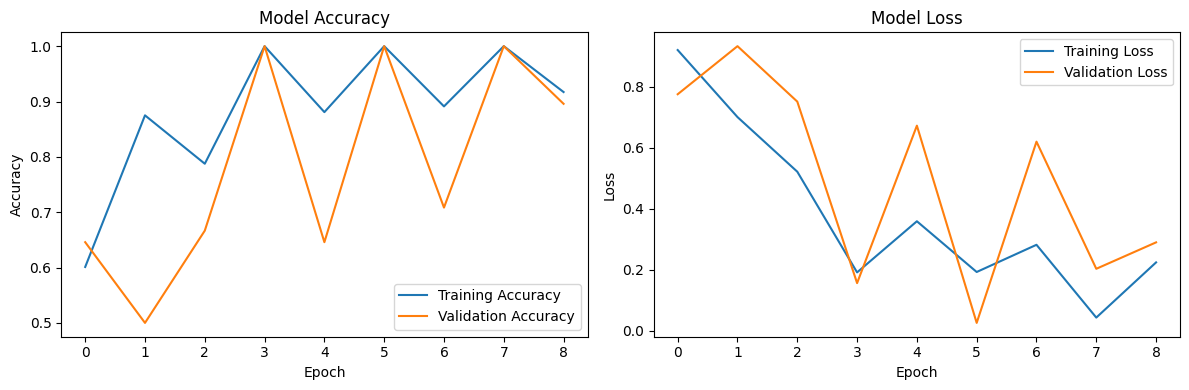

In [27]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9473 - loss: 0.3057
Test Accuracy: 0.9545


In [29]:
# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


In [30]:
# Generate classification report
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))


Classification Report:
                 precision    recall  f1-score   support

          Covid       0.96      0.92      0.94        26
         Normal       1.00      0.95      0.97        20
Viral Pneumonia       0.91      1.00      0.95        20

       accuracy                           0.95        66
      macro avg       0.96      0.96      0.96        66
   weighted avg       0.96      0.95      0.95        66



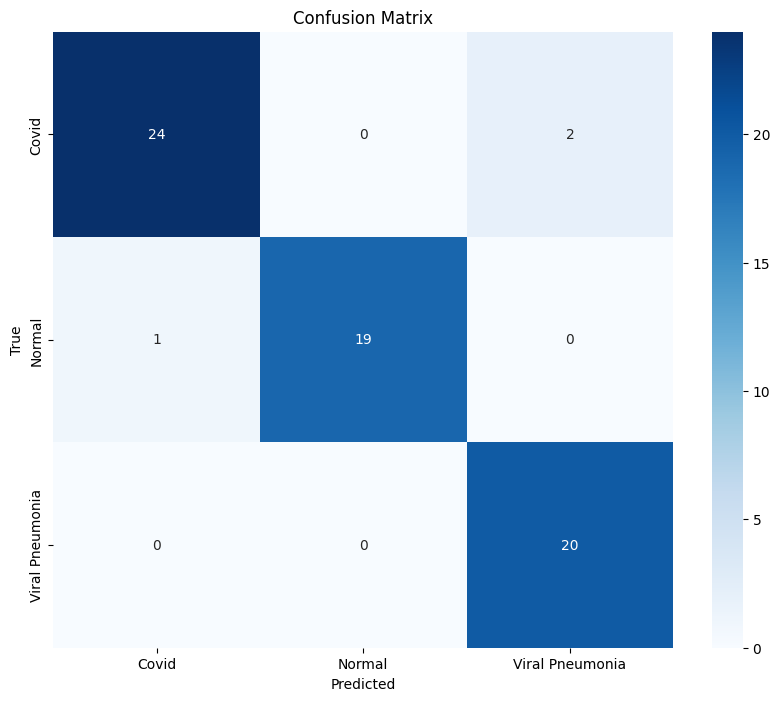

In [31]:
# Create and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()